In [26]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF

Text(0.5, 0, 'Output')

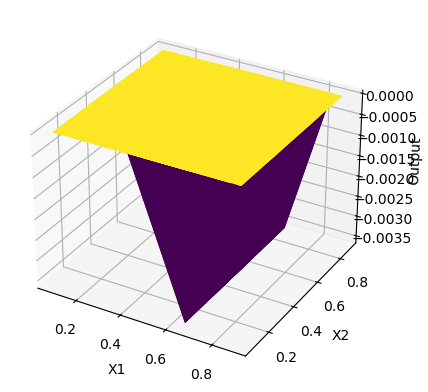

In [3]:
#mesh plot
ary1_in = np.load('../data/raw/initial_data/function_1/initial_inputs.npy')
ary1_out = np.load('../data/raw/initial_data/function_1/initial_outputs.npy')

x = ary1_in[:, 0]
y = ary1_in[:, 1]

X, Y = np.meshgrid(x, y)

# Reshape the output to fit the meshgrid layout for the surface plot
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = ary1_out[i]  


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Output')

In [13]:
#Output to CSV
interim_folder = '../data/interim'
for i in range(1,9):
    ary_in = np.load(f'../data/raw/initial_data/function_{i}/initial_inputs.npy')
    ary_out = np.load(f'../data/raw/initial_data/function_{i}/initial_outputs.npy')
    combined = np.append(ary_in, ary_out.reshape(-1,1), axis=1)
    np.savetxt(f'{interim_folder}/function_{i}.csv', combined, delimiter=',')



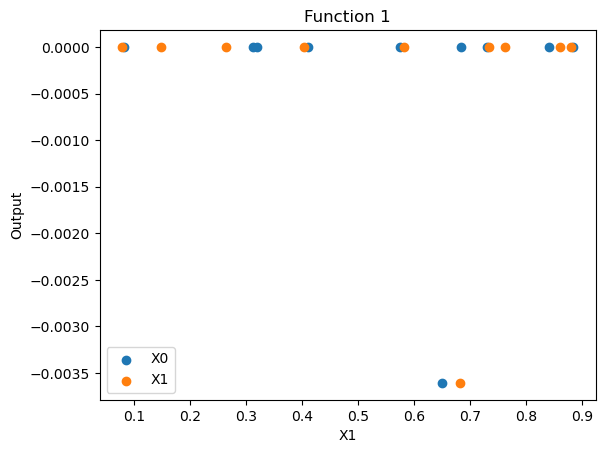

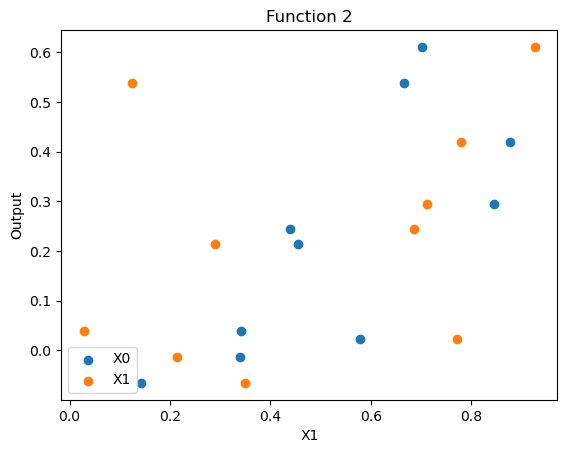

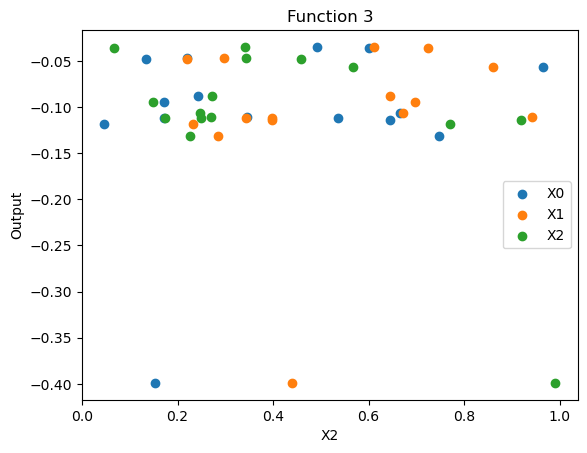

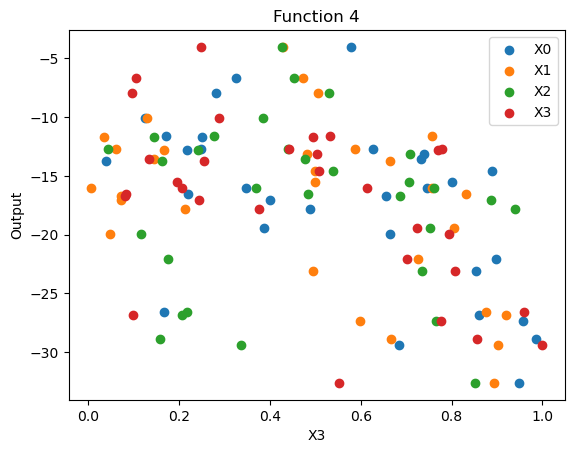

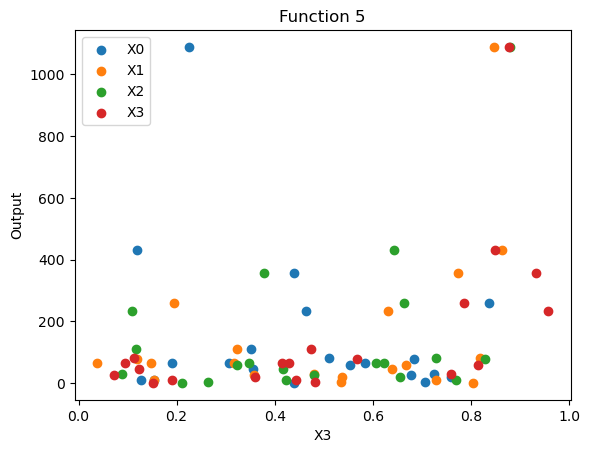

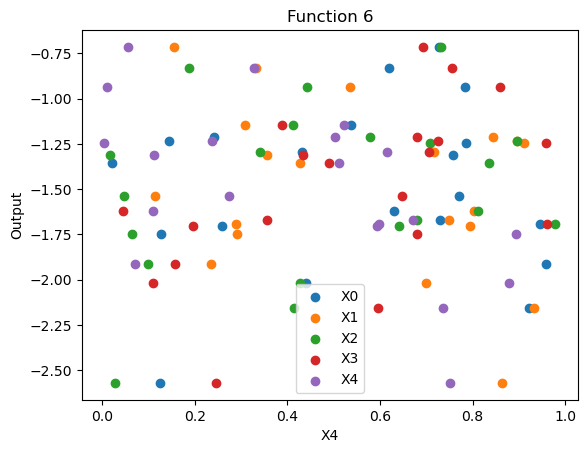

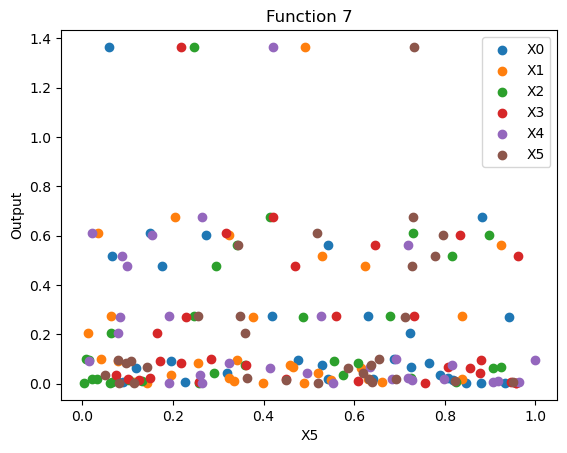

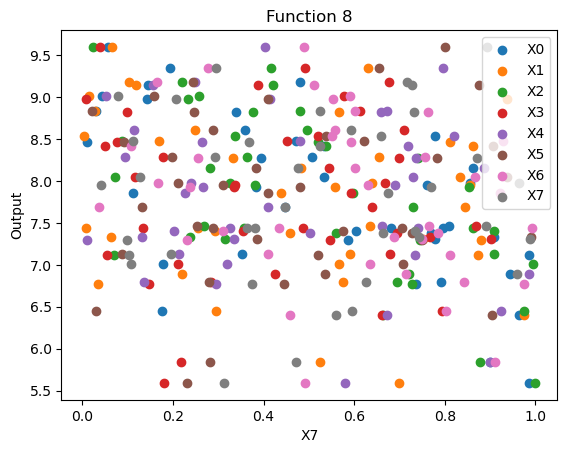

In [20]:
#Individual plot per function

def get_function_data(function_number):
    ary_in = np.load(f'../data/raw/initial_data/function_{function_number}/initial_inputs.npy')
    ary_out = np.load(f'../data/raw/initial_data/function_{function_number}/initial_outputs.npy')
    return ary_in, ary_out

for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    dimensions = ary_in.shape[1]
    fig = plt.figure()
    for x in range(0, dimensions):
        plt.scatter(ary_in[:, x], ary_out, label=f'X{x}')
        plt.xlabel(f'X{x}')
        plt.ylabel('Output')
        
        #plt.savefig(f'../reports/figures/function_{i}_X{x}_vs_output.png')
    plt.title(f'Function {i}')    
    plt.legend()
    plt.show()


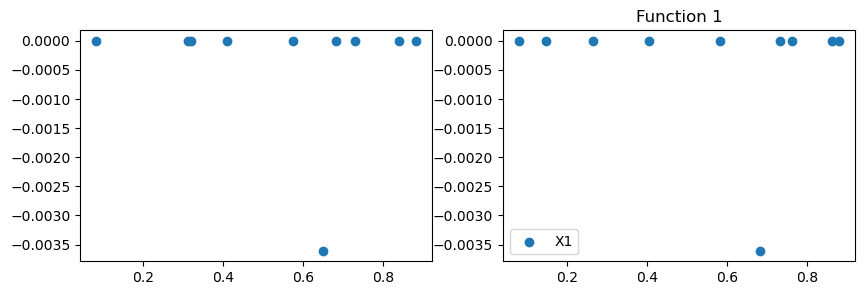

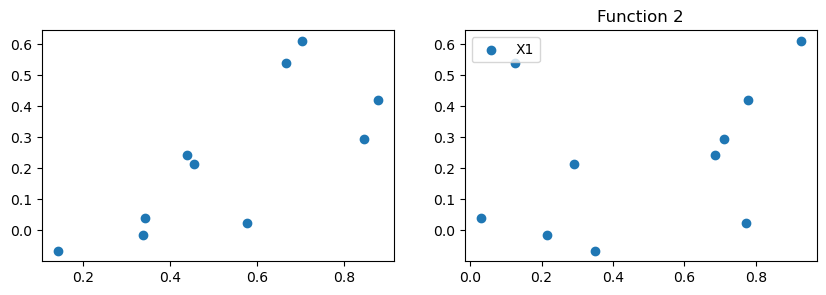

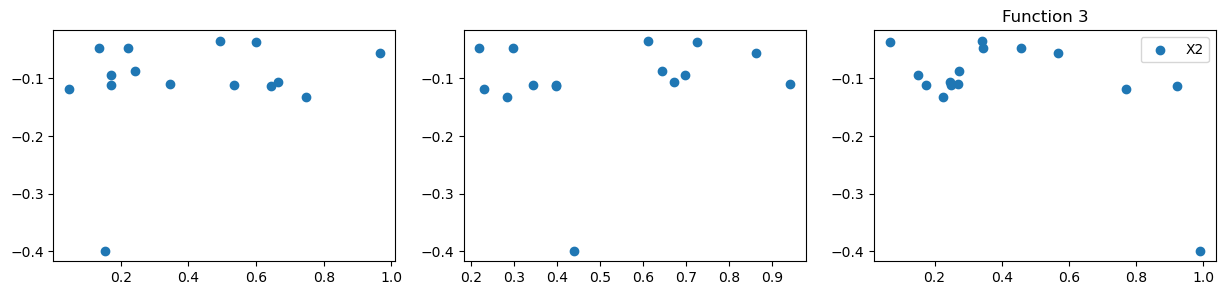

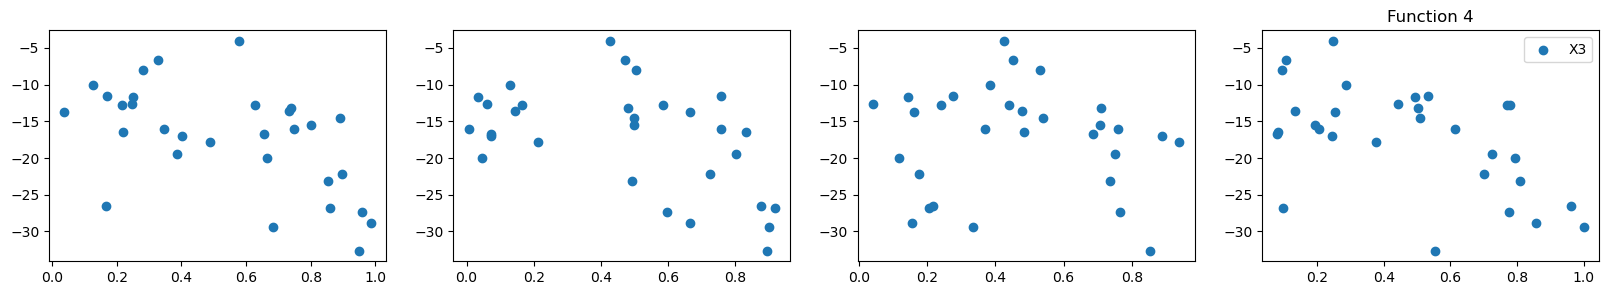

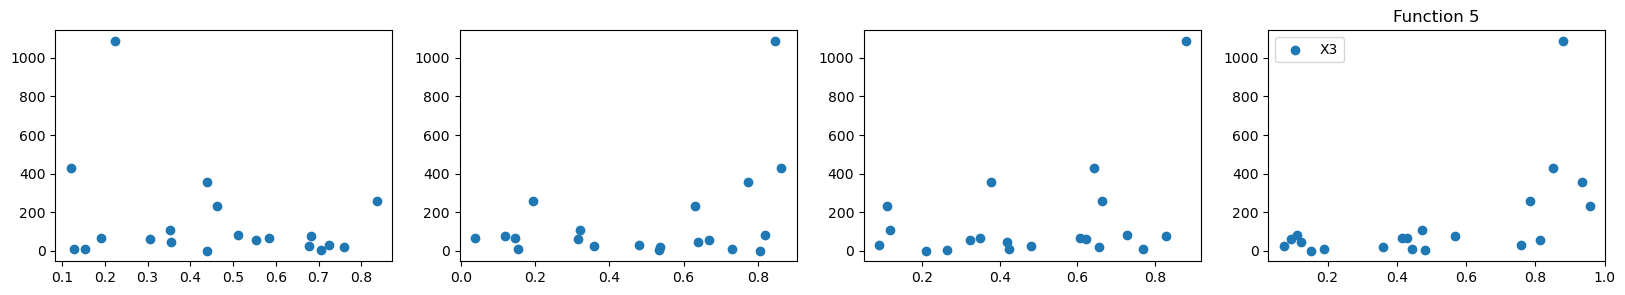

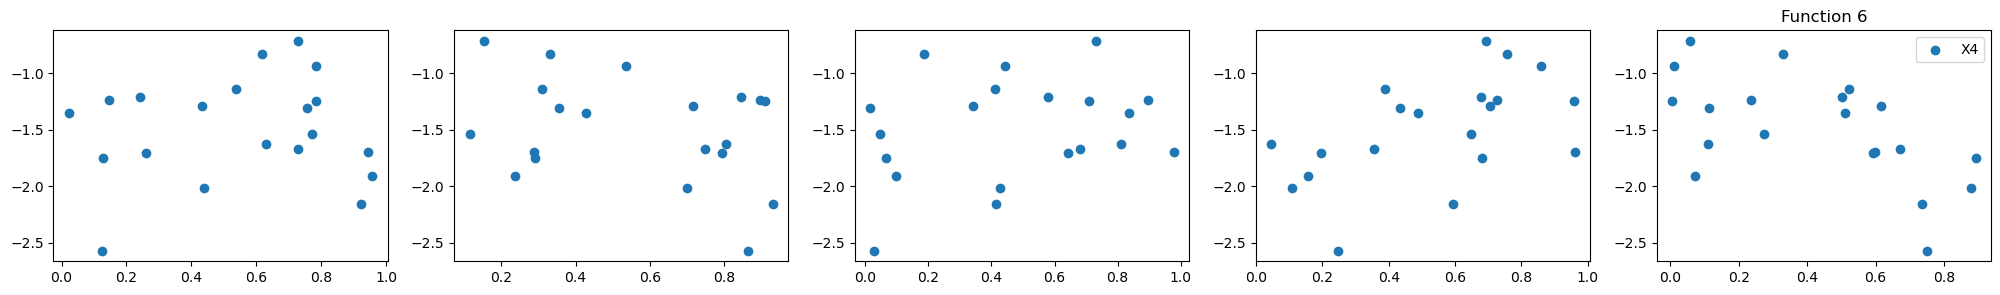

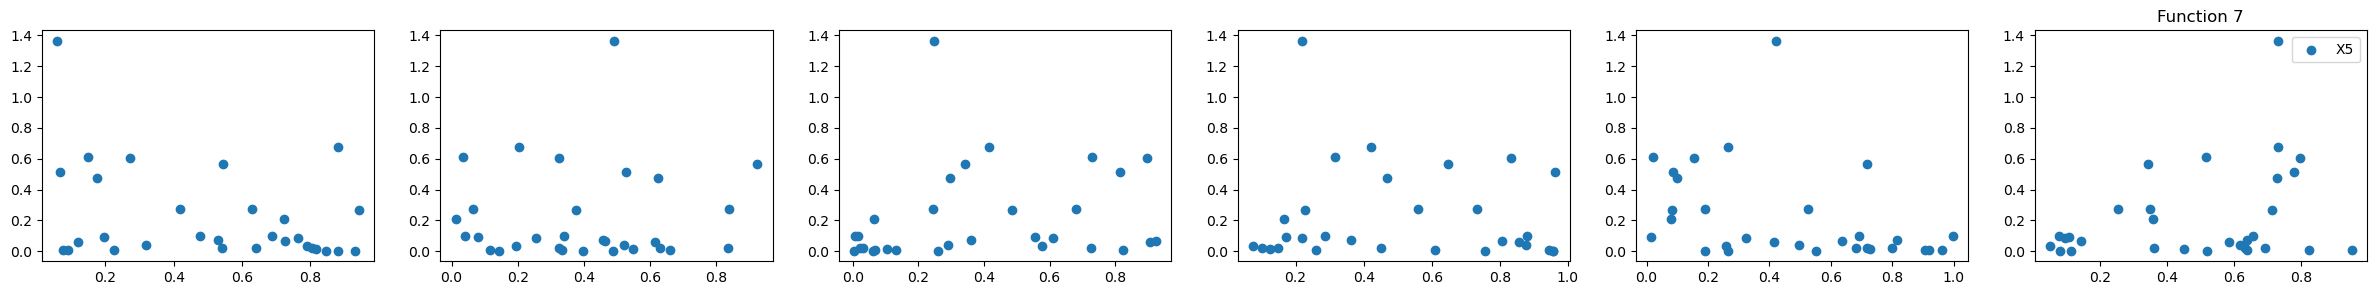

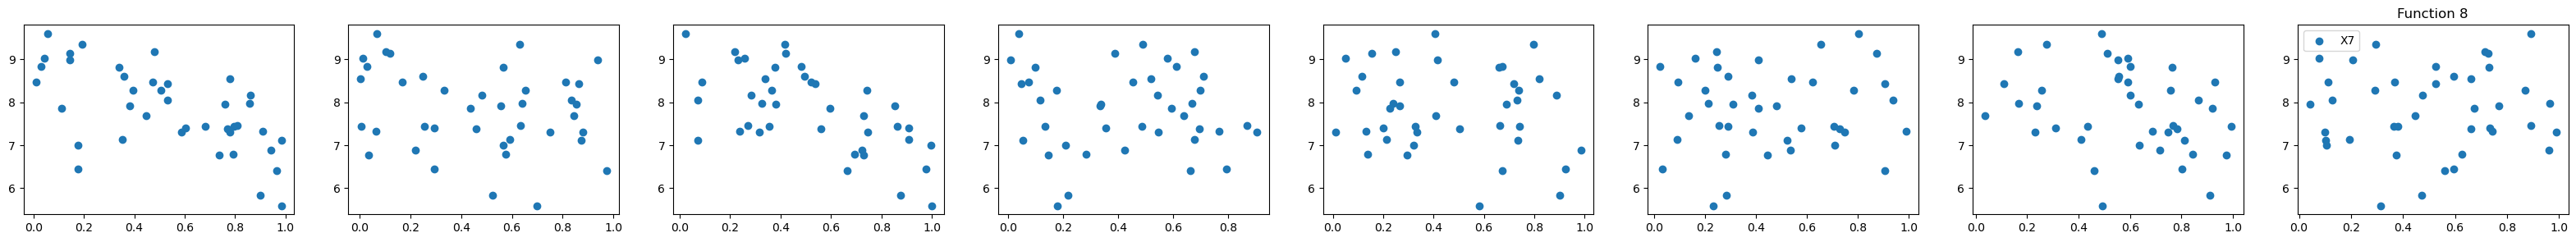

In [24]:
#Individual plot per parameter
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    dimensions = ary_in.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=dimensions, figsize=(5 * dimensions, 3))
    
    #fig.tight_layout()
    for x in range(0, dimensions):
        # sub = fig.add_subplot(1, dimensions, x+1)
        #sub.
        axes[x].scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.xlabel(f'X{x}')
        #sub.ylabel('Output')
        # sub.title = f'Function {i} input {x}'
        #plt.savefig(f'../reports/figures/function_{i}_X{x}_vs_output.png')
    plt.title(f'Function {i}')    
    plt.legend()
    plt.show()

In [39]:
def create_n_dimensional_grid(dimensions, num_points = 1001):
    """
    Create a grid for n dimensions.
    
    Parameters:
    - dimensions: number of dimensions (n)
    - num_points: number of points along each axis
    
    Returns:
    - A 2D array of shape (n_points, n_dimensions) where each row is a point in the n-dimensional space.
    """
    # Create a list of n-dimensional grids in range 0-1
    grids = [np.linspace(0, 1, num_points) for _ in range(dimensions)]
    
    # Create the n-dimensional meshgrid and then stack the ravel-ed grids together
    meshgrid = np.meshgrid(*grids)
    
    # Flatten the meshgrid and stack it together to get a 2D array of shape (n_points, n_dimensions)
    X_grid = np.vstack([g.ravel() for g in meshgrid]).T
    
    return X_grid

In [92]:
def format_for_submission(number_array):
    lst = number_array.tolist()
    formatted_numbers = [f"{n:.6f}" for n in lst]
    result = "-".join(formatted_numbers)
    return result

In [94]:
# Gaussian Process Acquisition Function (Upper Confidence Bound)
def ucb_acquisition(x, model, kappa=2.0):
    """
    UCB acquisition function for Bayesian Optimization.
    
    Parameters:
    - x: Point at which to evaluate the acquisition function.
    - model: GaussianProcessRegressor model.
    - kappa: Controls the exploration vs exploitation trade-off.
    
    Returns:
    - UCB acquisition value at point x.
    """
    # Predict the mean and standard deviation
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    
    # UCB acquisition function
    return mean + kappa * std

def lcb_acquisition(x, model, kappa=2.0):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean - kappa * std

# Function to suggest the next query point
def suggest_next_point(bounds, function_number, model, kappa=2.0):
    """
    Suggest the next point to query using Bayesian Optimization with Gaussian Process.
    
    Parameters:
    - X_existing: Array of input points already observed (n_samples, n_features).
    - Y_existing: Array of corresponding output values (n_samples,).
    - bounds: Bounds for each input dimension (n_features, 2).
    - model: Pre-trained GaussianProcessRegressor model (if available).
    - kappa: Exploration-exploitation trade-off parameter for UCB.
    
    Returns:
    - Next input point to query.
    """

    # Define the acquisition function to minimize (negative UCB)
    def acquisition_wrapper(x):
        if function_number in [1,2,5,7,8]: #maximise
            return -ucb_acquisition(x, model, kappa)
        elif function_number == 4: # minimise
            return lcb_acquisition(x, model, kappa) 
        else:
            # closest to 0. Get highest abs of (ucb or lcb) and minimize that
            return max(abs(lcb_acquisition(x, model, kappa)), abs(ucb_acquisition(x, model, kappa)))  # Minimize the negative of the acquisition function
    
    # Minimize the acquisition function to find the next point
    start_point = np.random.uniform(bounds[:, 0], bounds[:, 1])
    #print (f"Start point = {start_point}")
    res = optimize.minimize(acquisition_wrapper, start_point, bounds=bounds, method='L-BFGS-B')
    
    # Return the next query point
    return res.x

def at_bound(x):
    if (0 in x) or (1 in x):
        return True
    return False

# Suggest next points for each function
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    in_bounds = np.array([[0.0, 1.0]] * ary_in.shape[1])

    # fit gaussian process surrogate function
    kernel = RBF(length_scale=0.1, length_scale_bounds='fixed')
    #kernel = RationalQuadratic(length_scale=0.1, alpha=1.0)

    noise_assumption = 1e-1 # noise assumption, a hyper-parameter
    surrogate = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    surrogate.fit(ary_in, ary_out)

    next_point = [0]
    while at_bound(next_point):
        next_point = suggest_next_point(in_bounds, i, surrogate, kappa=2)
        #print(f"Function {i} Considering next point: {next_point})")
    submit = format_for_submission(next_point)
    print (f"Function {i} Next point to submit: {submit}")    

Function 1 Next point to submit: 0.003670-0.999900
Function 2 Next point to submit: 0.851999-0.973204
Function 3 Next point to submit: 0.747032-0.284130-0.226329
Function 4 Next point to submit: 0.169128-0.756136-0.275457-0.528761
Function 5 Next point to submit: 0.439601-0.772709-0.376277-0.933269
Function 6 Next point to submit: 0.232204-0.132714-0.538240-0.760706-0.075595
Function 7 Next point to submit: 0.476821-0.248196-0.242816-0.576157-0.162416-0.290926
Function 8 Next point to submit: 0.221603-0.703755-0.674607-0.130295-0.376739-0.669444-0.136655-0.061316
